In [1]:
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# Allow grouth option for CNN
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, BatchNormalization, GlobalAveragePooling1D
from keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import io

Using TensorFlow backend.


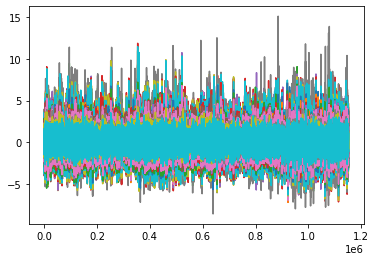

(50, 1152000)


In [4]:
set_num = 64
matdata = io.loadmat('data/signals.mat')
signals = numpy.zeros((50, 18000*set_num))
for i in range(set_num):
    signals[:,i*18000:(i+1)*18000]  = matdata['s'+str(i+1)]
plt.plot(signals.transpose())
plt.show()
print(signals.shape)

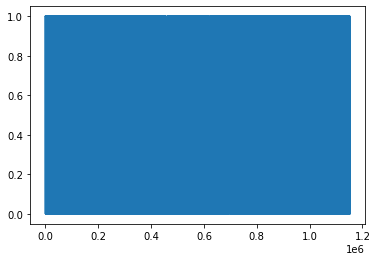

(1, 1152000)
0.6158940972222222


In [5]:
matdata = io.loadmat('data/behaviors.mat')
behavis = numpy.zeros((1, 18000*set_num))
for i in range(set_num):
    behavis[:,i*18000:(i+1)*18000]  = matdata['b'+str(i+1)]
plt.plot(behavis.transpose())
plt.show()
print(behavis.shape)
print(behavis.sum() / behavis.shape[1]) # Label proportion

In [6]:
dataset = numpy.hstack([signals.transpose().astype('float32'), behavis.transpose().astype('float32')])
print(dataset.shape)

(1152000, 51)


In [7]:
# # normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.5243208 , 0.4756588 , 0.52478135, ..., 0.52060586, 0.45601395,
        1.        ],
       [0.5294922 , 0.4874594 , 0.54577094, ..., 0.550915  , 0.44861886,
        1.        ],
       [0.53681123, 0.4916609 , 0.5472613 , ..., 0.5696357 , 0.44246095,
        1.        ],
       ...,
       [0.38074595, 0.3246355 , 0.42398232, ..., 0.33834928, 0.34063563,
        0.        ],
       [0.38334918, 0.31798124, 0.40275556, ..., 0.2984794 , 0.3288611 ,
        0.        ],
       [0.39405167, 0.34444982, 0.4290545 , ..., 0.3360081 , 0.3545482 ,
        0.        ]], dtype=float32)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 32/set_num)
valid_size = int(len(dataset) * 16/set_num)
test_size = len(dataset) - (train_size + valid_size)
train = dataset[0:train_size,:]
valid = dataset[train_size:(train_size + valid_size),:]
test = dataset[(train_size + valid_size):len(dataset),:]
print(len(train),len(valid), len(test))

576000 288000 288000


In [9]:
# convert an array of values into a dataset matrix
def create_dataset_back(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):i, j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

look_frame = 10 #前ｎフレームまで読み込んで入力とする
trainX, trainY = create_dataset_back(train, look_frame)
print(trainX.shape)
print(trainY.shape)
validX, validY = create_dataset_back(valid, look_frame)
print(validX.shape)
print(validY.shape)
testX, testY = create_dataset_back(test, look_frame)
print(testX.shape)
print(testY.shape)

(575990, 50, 10)
(575990,)
(287990, 50, 10)
(287990,)
(287990, 50, 10)
(287990,)


In [10]:
# transpose input
input_train = trainX.transpose(0,2,1)
input_valid = validX.transpose(0,2,1)
input_test = testX.transpose(0,2,1)
print(input_train.shape)
print(input_valid.shape)
print(input_test.shape)

(575990, 10, 50)
(287990, 10, 50)
(287990, 10, 50)


In [11]:
# callback設定
modelCheckpoint = ModelCheckpoint(filepath = 'best_mmodel.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [12]:
# create and fit the LSTM network
output_dim = 32 #modelの複雑さに合わせて決める
model = Sequential()
model.add(Conv1D(output_dim, 3, input_shape=(look_frame, trainX.shape[1])))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(output_dim, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(output_dim, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=input_train, y=trainY, validation_data=(input_valid, validY), epochs=100, batch_size=256, verbose=2, callbacks=[modelCheckpoint])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 32)             4832      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 32)             128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 32)             3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 32)             128       
_________________________________________________________________
activation_2 (Activation)    (None, 6, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 32)            


Epoch 00042: val_loss did not improve from 0.25967
Epoch 43/100
 - 13s - loss: 0.1191 - accuracy: 0.9549 - val_loss: 0.4451 - val_accuracy: 0.8179

Epoch 00043: val_loss did not improve from 0.25967
Epoch 44/100
 - 14s - loss: 0.1185 - accuracy: 0.9551 - val_loss: 0.2613 - val_accuracy: 0.9107

Epoch 00044: val_loss did not improve from 0.25967
Epoch 45/100
 - 14s - loss: 0.1182 - accuracy: 0.9552 - val_loss: 0.3624 - val_accuracy: 0.8737

Epoch 00045: val_loss did not improve from 0.25967
Epoch 46/100
 - 17s - loss: 0.1183 - accuracy: 0.9550 - val_loss: 0.2496 - val_accuracy: 0.9064

Epoch 00046: val_loss improved from 0.25967 to 0.24964, saving model to best_mmodel.h5
Epoch 47/100
 - 18s - loss: 0.1173 - accuracy: 0.9557 - val_loss: 0.4004 - val_accuracy: 0.8268

Epoch 00047: val_loss did not improve from 0.24964
Epoch 48/100
 - 18s - loss: 0.1172 - accuracy: 0.9555 - val_loss: 0.5492 - val_accuracy: 0.7891

Epoch 00048: val_loss did not improve from 0.24964
Epoch 49/100
 - 17s - lo


Epoch 00097: val_loss did not improve from 0.24147
Epoch 98/100
 - 19s - loss: 0.1029 - accuracy: 0.9608 - val_loss: 0.4062 - val_accuracy: 0.8609

Epoch 00098: val_loss did not improve from 0.24147
Epoch 99/100
 - 19s - loss: 0.1026 - accuracy: 0.9608 - val_loss: 0.3623 - val_accuracy: 0.8745

Epoch 00099: val_loss did not improve from 0.24147
Epoch 100/100
 - 19s - loss: 0.1027 - accuracy: 0.9607 - val_loss: 0.2884 - val_accuracy: 0.8976

Epoch 00100: val_loss did not improve from 0.24147


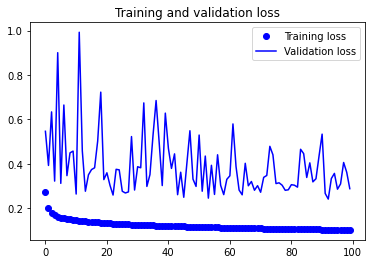

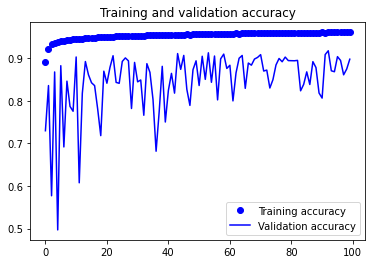

In [13]:
# plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [14]:
# Predict
model = load_model('best_mmodel.h5')
trainPredict = model.predict(input_train)
validPredict = model.predict(input_valid)
testPredict = model.predict(input_test)

In [15]:
# make predictions
pad_col = numpy.zeros(dataset.shape[1]-1)
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, dataset.shape[1]-1, x) for x in val])

trainPredict1 = scaler.inverse_transform(pad_array(trainPredict))
trainY1 = scaler.inverse_transform(pad_array(trainY))

validPredict1 = scaler.inverse_transform(pad_array(validPredict))
validY1 = scaler.inverse_transform(pad_array(validY))

testPredict1 = scaler.inverse_transform(pad_array(testPredict))
testY1 = scaler.inverse_transform(pad_array(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY1[:,dataset.shape[1]-1], trainPredict1[:,dataset.shape[1]-1]))
print('Train Score: %.2f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY1[:,dataset.shape[1]-1], validPredict1[:,dataset.shape[1]-1]))
print('Valid Score: %.2f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY1[:,dataset.shape[1]-1], testPredict1[:,dataset.shape[1]-1]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.21 RMSE
Valid Score: 0.25 RMSE
Test Score: 0.28 RMSE


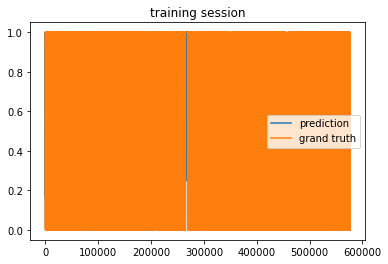

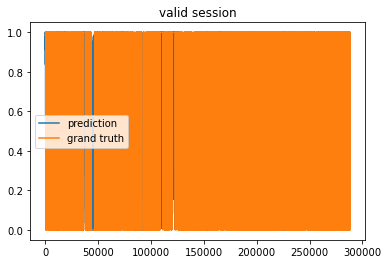

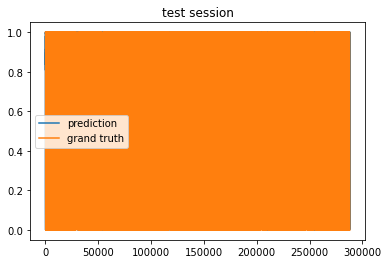

In [16]:
# plot baseline and predictions
plt.plot(trainPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(trainY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("training session")
plt.legend()
plt.show()
plt.plot(validPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(validY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("valid session")
plt.legend()
plt.show()
plt.plot(testPredict1[:,dataset.shape[1]-1], label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("test session")
plt.legend()
plt.show()

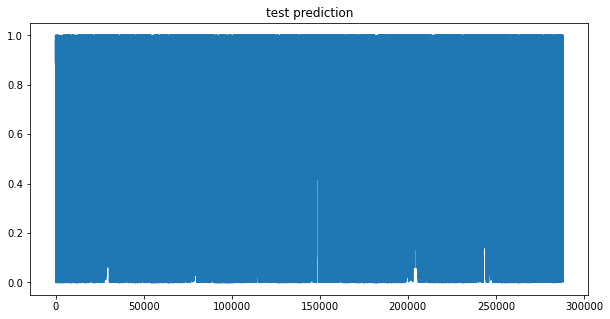

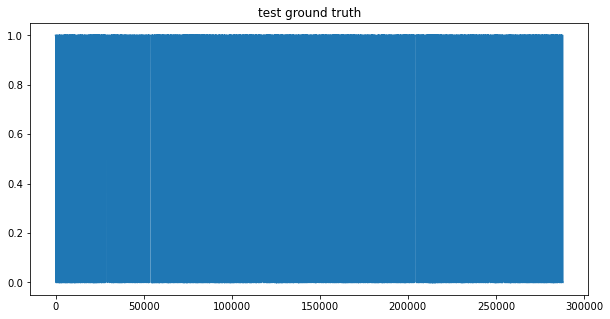

In [17]:
plt.figure(figsize=(10.0, 5.0))
plt.plot(testPredict1[:,dataset.shape[1]-1])
plt.title("test prediction")
plt.show()
plt.figure(figsize=(10.0, 5.0))
plt.plot(testY1[:,dataset.shape[1]-1])
plt.title("test ground truth")
plt.show()

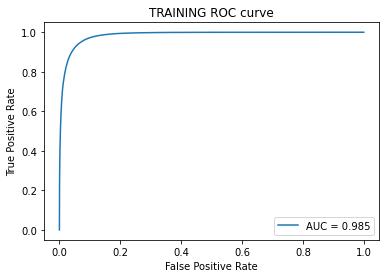

AUCは
0.9850470305394003
です。
最適な閾値は
0.6630929708480835
です。


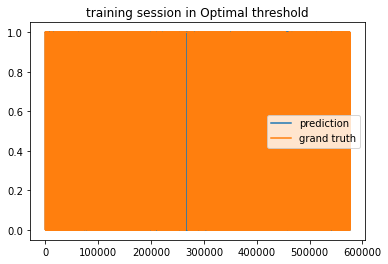

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

y_test, y_pred = trainY1[:,dataset.shape[1]-1], trainPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("TRAINING ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(trainPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(trainY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("training session in Optimal threshold")
plt.legend()
plt.show()

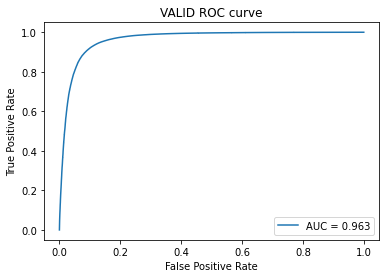

AUCは
0.9634036774437675
です。
最適な閾値は
0.7256996035575867
です。


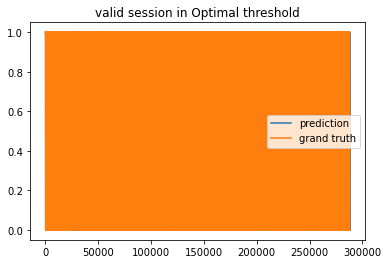

In [19]:
y_test, y_pred = validY1[:,dataset.shape[1]-1], validPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("VALID ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(testPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("valid session in Optimal threshold")
plt.legend()
plt.show()

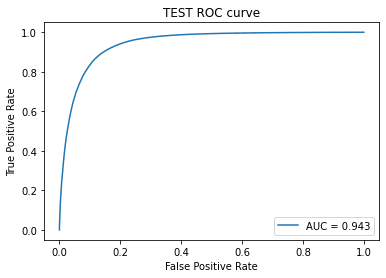

AUCは
0.9430860899855218
です。
最適な閾値は
0.8074432611465454
です。


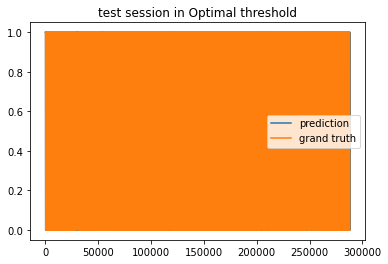

In [20]:
y_test, y_pred = testY1[:,dataset.shape[1]-1], testPredict1[:,dataset.shape[1]-1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
AUC = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("TEST ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[numpy.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(testPredict1[:,dataset.shape[1]-1] > opt_thr, label="prediction")
plt.plot(testY1[:,dataset.shape[1]-1], label="grand truth")
plt.title("test session in Optimal threshold")
plt.legend()
plt.show()

# shapによる判断根拠の可視化

可視化は1サンプルごとに結果が出るため、それを合計した。
全てのサンプルでの可視化には時間がかかるため、ランダムに200個選んで行った。

In [21]:
import shap
# model = load_model('best_mmodel.h5')
numpy.random.seed(seed=1)
num_tr = 200
train_idx = numpy.random.choice(range(input_train.shape[0]),num_tr)
num_te = 200
test_idx = numpy.random.choice(range(input_test.shape[0]),num_te)
print(train_idx)
print(test_idx )
explainer = shap.DeepExplainer(model, input_train[train_idx])
shap_value = explainer.shap_values(input_test[test_idx])

[128037 491755 470924 491263 371403  73349 117583  21440 229520 413825
 436973 293372 167302 513300  21758 176485 575956 457611 401660 365212
 188317 246322 294103 412649 148209  26103 444256 296022  99335 117565
 369977 128896 323900 194769 357640  58072 432755 506312 205895  99782
 540565 176643 338712 369137 130091 478234  28114 393231 510148 384738
 523929   1046 214142 454013 342949 545081 535123 486566 206112 438026
 507159    243 220462 250784 169688   5271 275825 501507 314240 447741
  33229 315861  63052  69595 555157 295627 350471  71757 101064 499020
 197675  78356 406375 304903  78788 470768 342226 404490  22807  81788
 190343  91850 212444 371104 441537 483934 478546 267123 488289 264322
 370396 113255 440162 368310  87904 254279 475111 390710 146309 420010
  88694 249741 395249 377441 296788 461834 237973  36071  56416 270291
 382449 264333 175316 353067 394957 310159 425097 270786  14535 449861
 313764 377701 191784 503885 362715  54575 296397 376232 562410  15917
 28307

In [22]:
shap_val = numpy.array(shap_value)
shap_val.shape

(1, 200, 10, 50)

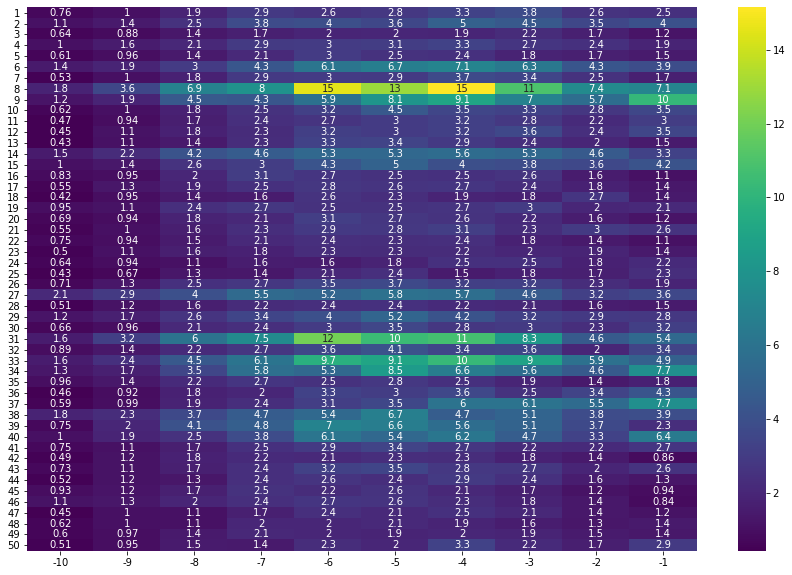

In [23]:
s = numpy.sum(numpy.abs(shap_val),axis=1).reshape([10,50])
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15.0, 10.0))
sns.heatmap(s.transpose(),cmap='viridis', annot=True)
plt.xticks( numpy.arange(0.5,10.5), numpy.arange(-10,0))
plt.yticks( numpy.arange(0.5,50.5), numpy.arange(1,51))
plt.show()